In [90]:
%reload_ext autoreload
%autoreload 2  

# Load data

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

file_name = "IrishNationalTideGaugeNetwork_8eaa_cdad_02f5.csv"
file_name_big = "IrishNationalTideGaugeNetwork_070c_f250_eaf8.csv"

file_name = file_name_big


df = pd.read_csv(file_name)
df.drop(columns=['latitude', 'longitude', 'Water_Level_OD_Malin'], inplace=True)
df = df.iloc[1:]
df['Water_Level_LAT'] = df['Water_Level_LAT'].astype(float)
mean_every_12_rows = df.groupby(df.index // 12)['Water_Level_LAT'].mean()[:500]

mean_every_12_rows

0      4.002364
1      3.524500
2      2.656333
3      1.775917
4      1.166417
         ...   
495    3.338750
496    2.592750
497    1.814750
498    1.290833
499    1.132000
Name: Water_Level_LAT, Length: 500, dtype: float64

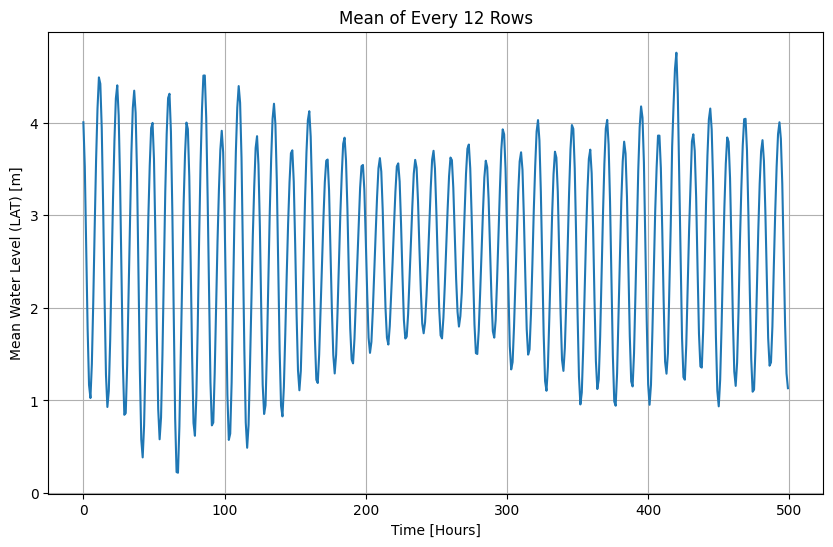

In [140]:
plt.figure(figsize=(10, 6))
plt.plot(mean_every_12_rows.index, mean_every_12_rows.values)
plt.title('Mean of Every 12 Rows')
plt.xlabel('Time [Hours]')
plt.ylabel('Mean Water Level (LAT) [m]')
plt.grid(True)
plt.show()

# Expectation matrix

### Format data

In [141]:
import numpy as np
data = np.array(mean_every_12_rows)
print(data.shape)
print(data[0])

# Rescale the data to be between 0 and 2np.pi
data = (data - data.min())/(data.max() - data.min()) * 2 * np.pi
data[150]

# get training data
train_x = data[:-30]
print(train_x.shape)

# # get test data
# test_x = data[-30:]
# print(test_x.shape)

(500,)
4.002363636363636
(470,)


In [142]:
m = 9

n = (m-1)*5

train_matrix = np.tile(data, (n, 1)).transpose()
print("train_matrix.shape: ", train_matrix.shape)
train_matrix[:2] 

# # prediction matrix
# test_matrix = np.tile(test_x, (n, 1)).transpose()
# print("test_matrix.shape: ", test_matrix.shape)

train_matrix.shape:  (500, 40)


array([[5.24240043, 5.24240043, 5.24240043, 5.24240043, 5.24240043,
        5.24240043, 5.24240043, 5.24240043, 5.24240043, 5.24240043,
        5.24240043, 5.24240043, 5.24240043, 5.24240043, 5.24240043,
        5.24240043, 5.24240043, 5.24240043, 5.24240043, 5.24240043,
        5.24240043, 5.24240043, 5.24240043, 5.24240043, 5.24240043,
        5.24240043, 5.24240043, 5.24240043, 5.24240043, 5.24240043,
        5.24240043, 5.24240043, 5.24240043, 5.24240043, 5.24240043,
        5.24240043, 5.24240043, 5.24240043, 5.24240043, 5.24240043],
       [4.58019254, 4.58019254, 4.58019254, 4.58019254, 4.58019254,
        4.58019254, 4.58019254, 4.58019254, 4.58019254, 4.58019254,
        4.58019254, 4.58019254, 4.58019254, 4.58019254, 4.58019254,
        4.58019254, 4.58019254, 4.58019254, 4.58019254, 4.58019254,
        4.58019254, 4.58019254, 4.58019254, 4.58019254, 4.58019254,
        4.58019254, 4.58019254, 4.58019254, 4.58019254, 4.58019254,
        4.58019254, 4.58019254, 4.58019254, 4.5

### Generate circuit object

In [143]:
import perceval as pcvl
import lo_reservoir as lrs

t_max_train = train_matrix.shape[0]
memory_length = 7

simulator = lrs.PhotonicReservoirSimulator(m, t_max_train, overlapping=True)

# generate the layers
_ = simulator.set_circuit_with_stored_layers()

Generating layers: 100%|██████████| 500/500 [00:01<00:00, 338.53it/s]


In [144]:
input_state = pcvl.BasicState([1]*(m-1) + [0]*1)
# input_state = pcvl.BasicState([0, 1, 0, 1, 0, 1, 0, 1])
# train_expectation_matrix = simulator.sequential_expectation_with_memory(train_matrix, 
#                                                                         input_state, memory_length=memory_length)
full_expectation_matrix = simulator.sequential_expectation_with_memory(train_matrix, 
                                                                        input_state,
                                                                        memory_length=100)
print("expectations_matrix.shape = ", np.array(full_expectation_matrix).shape)

Processing time steps:  21%|██        | 104/500 [00:13<01:03,  6.22it/s]

In [ ]:
# Train Test split

split_int = 75

test_expectation_matrix = full_expectation_matrix[-split_int:]
train_expectation_matrix = full_expectation_matrix[:-split_int]
print("train_expectation_matrix.shape = ", np.array(train_expectation_matrix).shape)
print("test_expectation_matrix.shape = ", np.array(test_expectation_matrix).shape)


test_x = data[-split_int:]
train_x = data[:-split_int]

train_expectation_matrix.shape =  (225, 9)
test_expectation_matrix.shape =  (75, 9)


# Quadratic Regression

In [134]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# Assuming 'train_expectation_matrix' and 'train_x' are defined and available

# Pop the last row of expectations_matrix
expectations_matrix_red = np.array(train_expectation_matrix)[:]
print("expectations_matrix.shape = ", expectations_matrix_red.shape)

# Make prediction vector
labels = np.array(train_x)[:]
data_red = np.array(train_x)[:]
print("labels:", labels[:3])
print("data_red: ", data_red[:4])
print("labels shape: ", labels.shape)

# Transform the data to include quadratic terms
poly = PolynomialFeatures(degree=10)
expectations_matrix_quad = poly.fit_transform(expectations_matrix_red)

# Fit the quadratic model with Ridge regularization
# You can adjust the alpha parameter to control the strength of the regularization
reg_ridge = Ridge(alpha=3).fit(expectations_matrix_quad, labels)

# 'reg_ridge' is now a Ridge regression model fit to the quadratic terms


expectations_matrix.shape =  (225, 9)
labels: [5.542394   4.84229161 3.57036902]
data_red:  [5.542394   4.84229161 3.57036902 2.28049935]
labels shape:  (225,)


In [135]:
test_expectation_matrix_quad = poly.fit_transform(test_expectation_matrix)

# Make predictions using the quadratic model
predicted_test_data_quad = reg_ridge.predict(test_expectation_matrix_quad)
print("predicted_data.shape = ", predicted_test_data_quad.shape)

# Rescale the prediction data (if necessary)
# Assuming 'rescale' is a function or a method you have defined for rescaling
# rescaled_predicted_data = rescale(predicted_data_quad)

# Print predictions
print(predicted_test_data_quad)



predicted_data.shape =  (75,)
[ 5.00642255  2.62693577  4.10996153  3.46870471  1.83333037  3.56906612
  2.67568359  1.28795025  3.88007062  4.19039521  6.16068496  4.47992047
  4.03606139  2.59666478  0.78361599  4.13088161  4.69767726  3.52333762
  3.96549544  2.35930598  4.28178947  4.81890458  3.31793918  1.00818991
  5.43811219  3.8269091   2.53219118  1.81638392  3.12481399  4.63723027
  3.06328005  2.91101592  3.41537838  2.59134448  4.58486188  4.47434916
  5.46997204  4.42568583  3.00501268  4.20235561  2.97510181  2.16395213
  3.29722554  4.3017601   2.5698644   5.08688349  4.8726556   3.79238863
  1.88590249  2.68837948  2.92111451  1.20599209  2.54407002  4.01402949
  4.33801221  5.02174618  4.12923391  6.30002177  2.19780388  2.14973356
  5.09330402  3.99509285  2.73295461  3.95193961  3.00513301  4.96565446
  3.64397948  5.1232271   2.809029   -0.15780422  1.29030892  4.55875114
  2.942129    3.15109009  3.13145429]


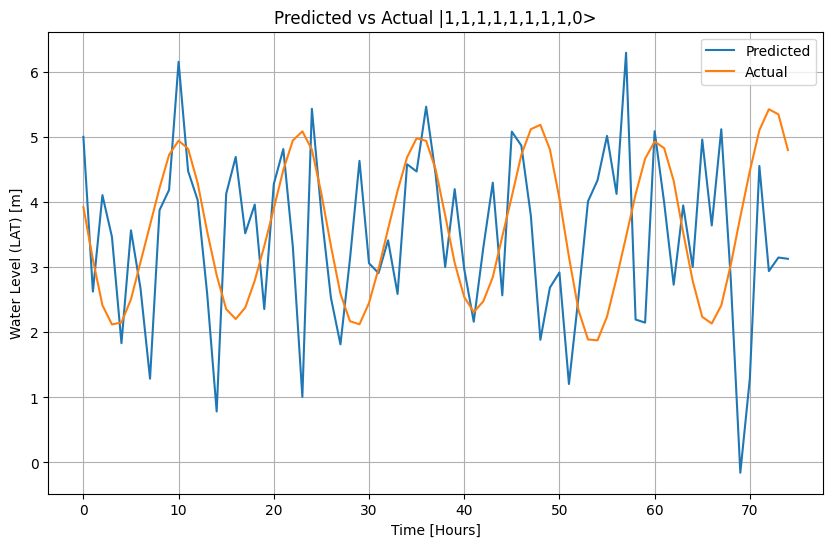

In [136]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(predicted_test_data_quad, label=f'Predicted')
plt.plot(test_x, label='Actual')
plt.title(f'Predicted vs Actual {input_state}')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()
plt.grid(True)


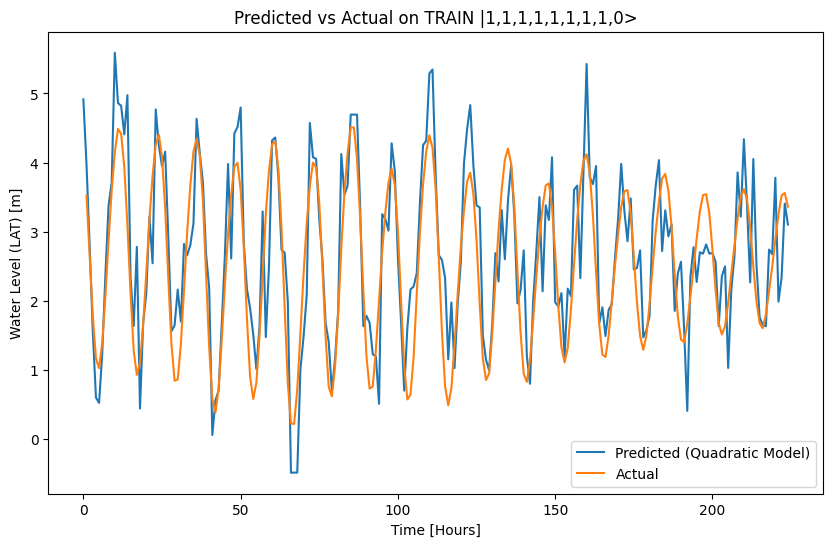

In [137]:
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Assuming 'reg_quad' is your trained quadratic model and 'train_expectation_matrix' is available

# Transform the training data to include quadratic terms
train_expectation_matrix_quad = poly.fit_transform(train_expectation_matrix)

# Make predictions using the quadratic model
predicted_train_data_quad = reg_ridge.predict(train_expectation_matrix_quad) - 0.7

# Assuming 'other_data' is already defined and represents the actual values
other_data = mean_every_12_rows[1:-split_int]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(predicted_train_data_quad, label='Predicted (Quadratic Model)')
plt.plot(other_data, label='Actual')
plt.title(f'Predicted vs Actual on TRAIN {input_state}')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()
plt.show()


# Plot full data

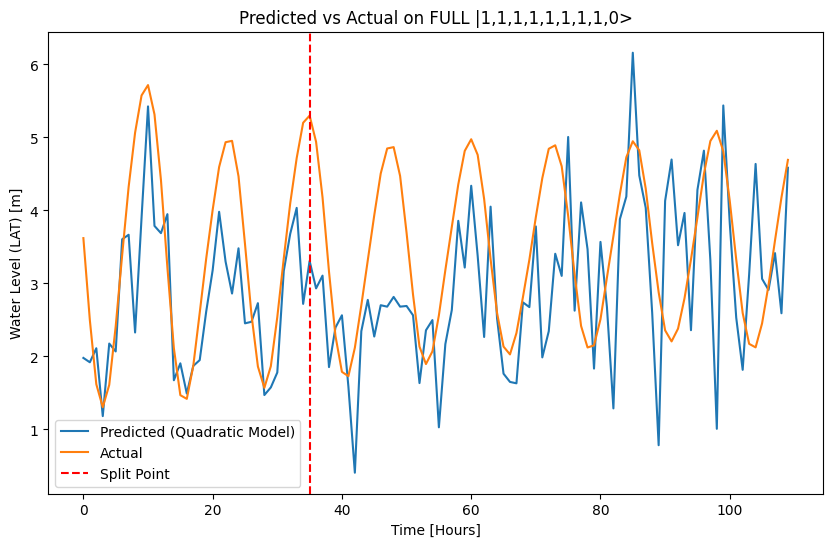

In [138]:
# append predicted train quad and test quad
FULL_data_quad = np.append(predicted_train_data_quad, predicted_test_data_quad)[150:-40]



# Plotting
plt.figure(figsize=(10, 6))
plt.plot(FULL_data_quad, label='Predicted (Quadratic Model)')
plt.plot(data[150:-40], label='Actual')
plt.axvline(x=len(FULL_data_quad)-split_int, color='r', linestyle='--', label='Split Point')
plt.title(f'Predicted vs Actual on FULL {input_state}')
plt.xlabel('Time [Hours]')
plt.ylabel('Water Level (LAT) [m]')
plt.legend()
plt.show()
